In [1]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import pandas as pd
import numpy as np
import os, shutil

C:\Users\akams\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\akams\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\akams\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\akams\anaconda3\envs\learn-env\lib\site-packages\ten

# Exploratory Data Analysis
We will start off this classification process with exploratory data analysis, to get a good idea of the data we are working with. Good and thorough EDA will help us generate better models at the end.

In [14]:
# randomly select 5 images from each calss type
select_norm = np.random.choice(normal_imgs, 5, replace = False)
select_pneu = np.random.choice(pneumonia_imgs, 5, replace = False)
print(select_norm)
print(select_pneu)

['NORMAL-8336355-0001.jpeg' 'NORMAL-4090456-0001.jpeg'
 'NORMAL-9019297-0002.jpeg' 'NORMAL-1068326-0001.jpeg'
 'NORMAL-202916-0004.jpeg']
['VIRUS-6144452-0004.jpeg' 'BACTERIA-8352680-0002.jpeg'
 'VIRUS-6275436-0002.jpeg' 'VIRUS-7603659-0001.jpeg'
 'BACTERIA-6870430-0004.jpeg']


Our output tells us that we have 3 types of images in our dataset. We have normal x-rays and 2 types of Pneumonia infections: **Bacterial** and **Viral**. This may help us later further analyze images to help the model learn the data better to make more precise distinctions.

In [16]:
# create funtion to visualize possible class imbalances
def plot_class_imbalances(class_normal, class_peumonia, class_type):
    ax = sns.barplot(x = ['Normal', 'Pneumonia'], y = [class_normal, class_peumonia], palette = 'pink_r');
    ax.set_title(f'{class_type} Class Imbalance');
    ax.set_xlabel('Class Type')
    ax.set_ylabel('Frequency')
# plt.savefig("normal_pnuemo_classimbalance.png", bbox_inches='tight')

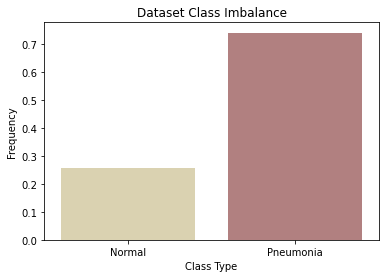

In [17]:
plot_class_imbalances(normal_size, pneumo_size, "Dataset")

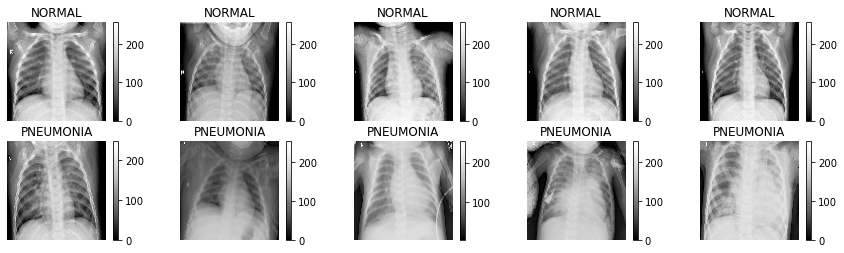

In [18]:
# plotting 5 images from each class 
fig = plt.figure(figsize = (15,4))
for i in range(10):
    if i < 5:
        filepath = f'{data_normal_dir}/{select_norm[i-3]}'
        label = 'NORMAL'
    else:
        filepath = f'{data_pneumonia_dir}/{select_pneu[i-8]}'
        label = 'PNEUMONIA'
    ax = fig.add_subplot(2, 5, i+1)
    
    # to plot without rescaling, remove target_size
    filename = image.load_img(filepath, target_size = (100,100), color_mode='grayscale')
    plt.imshow(filename, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')
    plt.colorbar()
plt.savefig("5normal_5pnuemo.png" ,bbox_inches='tight')    
plt.show()

After looking at 5 random images from both classes, we noticed 2 types on pneumonia infections, bacterial and viral. So, with that, we can isolate these infection types to analyze them further and see if we can find any notable distinguishing features and characteristics.

In [19]:
# compare viral to bacterial pnuemonia
# assign empty lists to hold images
viral = []
bacterial = []
for x in pneumonia_imgs:
#     split file names to isolate each character
    if x.split()[0][0] == 'V': # where 'V' is the first letter of the filename, we assume a viral pneumonial infection
        viral.append(x) # append viral infection images to viral list
    else:
        bacterial.append(x) # append bacterial infection images to bacterial list
        

From gathering domain information of this medical topic, I came across the statistic that approximately 30% of pneumonia infections are a result of a virus. We can attempt to confirm or refute this statistic simply by getting a distribution percentage of viral vs bacterial infections.

In [20]:
# check pneumonia type percentages
bac_perc = len(bacterial)/ len(pneumonia_imgs) # divide total bacterial pneumonia train images by total pneumonia train images
vir_perc = len(viral)/len(pneumonia_imgs) # divide total viral pneumonia train images by total pneumonia train images

# multpliy by 100 to get a percentage
print(bac_perc * 100)
print(vir_perc * 100)

65.36183363378831
34.63816636621169


As we can see by the above percentages, the general statistic that approx. 30% of pneumonia infections are viral holds somewhat true, relative to our specific training dataset. Interesting.


Now that we have our data nicely organized, we can start to really look at their differences. First, we'll start by building a function that will convert every image in a matrix that can be flattened into a 1-dimensional array, which we will use to plot our images.


In [21]:
# create a function for making an n X m matrix
def img_to_np_array(path, list_of_fns, size = (64, 64)):
    # iterating through each file
    for file_n in list_of_fns:
        file_p = path + '/' + file_n
        current_image = image.load_img(file_p, target_size = size, 
                                       color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # flatten image to a 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_matrix = np.concatenate((full_matrix, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_matrix = img_ts
    return full_matrix

# run it on our folders
normal_img_array = img_to_np_array(data_normal_dir, normal_imgs)
pneumonia_img_array = img_to_np_array(data_pneumonia_dir, pneumonia_imgs)

In [22]:
# comparing viral to bacterial pnuemonia
viral_img_array = img_to_np_array(data_pneumonia_dir, viral)
bacterial_img_array = img_to_np_array(data_pneumonia_dir, bacterial)

After creating the function to flatten our data arrays, we can calculate the average for each class and type of class. This is what we will plot to get a very general idea about x-ray image differences.

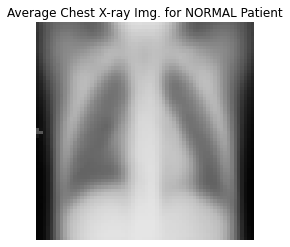

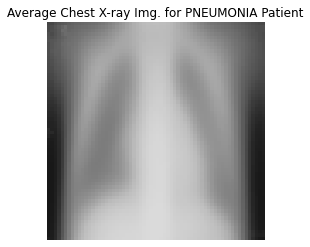

In [23]:
# create a function to calculate average 
def find_mean_img(full_matrix, title, size = (64, 64)):
    # calculate the average
    mean_img = np.mean(full_matrix, axis = 0) 
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average Chest X-ray Img. for {title} Patient')
    plt.axis('off')
    plt.savefig(f"avg_{title}.png" ,bbox_inches='tight')
    plt.show()
    return mean_img

# compare findings
norm_mean = find_mean_img(normal_img_array, 'NORMAL')
pneu_mean = find_mean_img(pneumonia_img_array, 'PNEUMONIA')

From the images above, we can see that there is are slight differences between normal and pneumonia chest x-rays. For one, pneumonia chest x-rays seem to be cloudier and fuzzier, like there is a filter over the image. Also, interestingly, while the heart seems to appear larger in Pneumonia patients as opposed to normal patients, the diaphragm appears less defined and smaller.


We would not expect to see a significant difference due to the nature of a pneumonia infection being one that is a space-occupying lesion that does not heavily affect organ volume. This could be a possible challenge for the model to overcome.


These differences do not seem too out of the ordinary because in a typical pneumonia chest x-ray, radiologists will usually look for white spots in the lungs, called infiltrates, which will give the x-ray a cloudier appearance. Labored breathing is often a symptom of pneumonia, so the reduced size of the diaphragm of an infected patient may explain why it is difficult for these patients to circulate air throughout the body and lungs. The diaphragm is not working at optimal capacity to allow for comfortable breathing from the patient.


As for the difference in heart sizes, this can be attributed to pneumonia pushing the heart into abnormally fast rhythms. These are referred to as atrial fibrillation, atrial tachycardia, or arterial flutter. The fast nature of an infected person’s heart beat can put a lot of stress on the heart. Like any other muscle in the body, if it is working, it will grow.


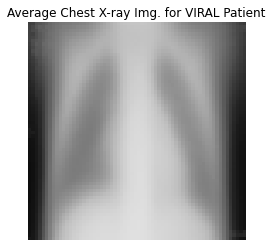

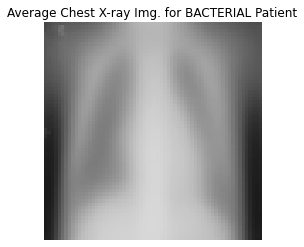

In [24]:
viral_mean = find_mean_img(viral_img_array, 'VIRAL')
bacterial_mean = find_mean_img(bacterial_img_array, 'BACTERIAL')

In [25]:
len(bacterial)/len(pneumonia_imgs)

0.6536183363378831

From our generated images above, we can see the slightest difference in brightness between these two types of respiratory infections. These findings seem to be consistent with the knowledge that bacterial infections cause more mucous build up in the lungs, which, in an x-ray, will appear cloudy in an image, indicating fluid is present. 


Grayscale images are a nice way to compare images to find obvious differences, but we can to get more into it. We can build a function that will compare our images by plotting a contrast of image pixel intensity.


In [26]:
# create a function to plot and graph average pixel intensity distribution 
def plot_graph_difference(img_mean_1, img_mean_2, img1, img2):
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20, 5))

    contrast_mean = img_mean_1 - img_mean_2
    ax[0].imshow(contrast_mean, cmap='coolwarm')
    ax[0].set_title(f'Difference Between {img1} & {img2} Patient Chest X-rays Average')
    ax[0].axis('off')

    # visualize pixel instensity distributions
    img_arr_2 = img_mean_2.ravel()
    img_arr_1 = img_mean_1.ravel()


    # Create a dataframe
    img1_img2 = pd.DataFrame([(img_arr_2),(img_arr_1)]).T
    img1_img2.columns = [f'{img2}', f'{img1}']

    plt.savefig(f"avg_diff_{img2}_vs_{img1}.png" ,bbox_inches='tight')
    sns.boxplot(data=img1_img2, ax=ax[1], palette = 'coolwarm');
    ax[1].set_title(f"Distribution of pixel intensity \n between {img2} and {img1} Patient chest X-rays", size=14);

Plotting the distribution of pixel intensity, or brightness, will help us clearly see where one class or type is more prominent. The more of that color in that region, the more intense its pixels are in that region. This may suggest some special activity about the disease. We can use these images along with domain knowledge to make some insights. 

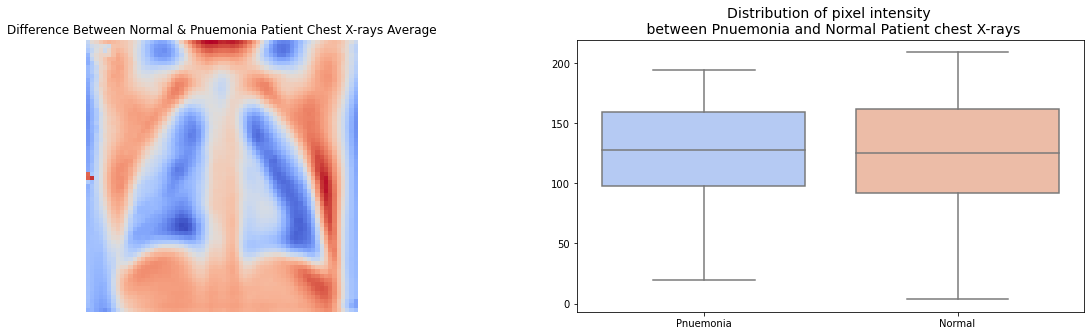

In [27]:
plot_graph_difference(norm_mean, pneu_mean, 'Normal', 'Pnuemonia')

From the pixel intensity distributions shown above, we see that normal chest x-rays have a wider range of pixel intensities but overall, Pneumonia x-rays showed higher intensities. This finding is not surprising to us because as we already saw from our earlier visualizations, pneumonia x-rays appear cloudier and lighter, or in other words, appear to have a higher intensity.


We are not surprised to see more intense activity coming from the lungs for pneumonia patients, because pneumonia is a respiratory disease.


We can try to assume that normal x-rays have a wider range of pixel intensity due to its more defined, healthy features, but that would be an assumption in need of confirmation using patient age to infer skeletal, organ, and cartilage development.

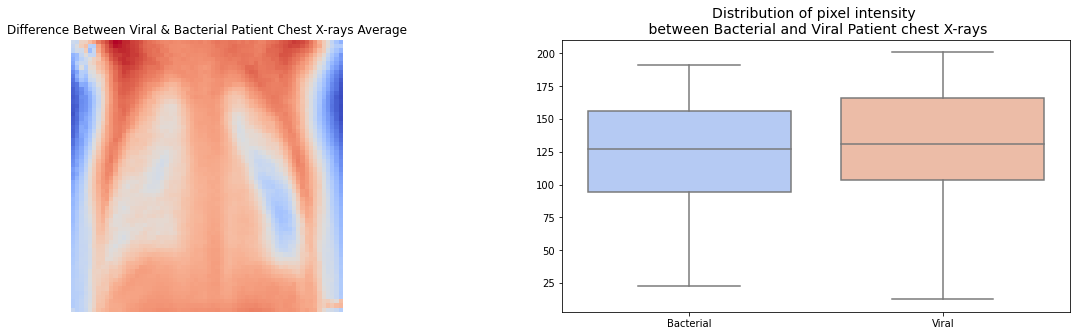

In [28]:
plot_graph_difference(viral_mean, bacterial_mean, 'Viral', 'Bacterial')

To further analyze pneumonia chest x-rays, we look at a contrast comparison of images for bacterial versus viral pneumonia.


Our overall findings show that viral pneumonia may play a bigger role in infection prognosis and diagnosis. However, the spot of blue that we can see in the lungs suggest that Streptococcus pneumoniae, the causing bacteria of pneumococcal pneumonia, is mainly cultivated and most harmful in the lungs compared to a virus. This can be backed up with the common symptoms expressed from these two infections.


Viral infections tend to be drier and rarely cause the buildup of sputum. This piece of information seems to be in slight opposition with our findings. We can see spurts of blue within the red of the lungs. This suggests and confirms our knowledge that bacterial infections cause more mucus and sputum build up, so it would appear cloudier and brighter inside the lungs, where this build up is happening.


# EDA Insights and Takeaways
From the insights and take away listed below, we can train our model to focus on those specific insights to learn the data better and build a high accuracy model.
* **Class Imbalances**: There is clearly a class imbalance between normal patient and pneumonia patient x-rays. To help our model overcome this, weighing the data differently would help the model avoid overfitting and mainly classifying images as pneumonia simply because it is more abundant.
* **Feature Selection**: While training our CNN model, we hope it will be able to pick up on the few distinguishing features we were able to gather from performing data analysis.
    * cloudy pneumonia chest x-rays
    * larger heart relative to diaphragm
    * pixel intensity between different classes and types of class


In [ ]:
from keras import models
from keras import layers
import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import precision_recall_fscore_support as score

## **Reading in the data**

In [ ]:
train_folder = '/Users/alexandrabruno/Documents/flatiron/phase_4_project/CellData_2/chest_xray/split/train'
val_folder = '/Users/alexandrabruno/Documents/flatiron/phase_4_project/CellData_2/chest_xray/split/validation'
test_folder = '/Users/alexandrabruno/Documents/flatiron/phase_4_project/CellData_2/chest_xray/split/test'

The reason as to why we chose to make our target size 256,256 is because our pictures have high resolution. Making the images larger would allow us to capture more information about the picture.

We chose to shuffle the images in the train and validation sets because we wanted to train our model to get better at predicting unforseen images, having a shuffled set of images within each batch would help to do this. 

In [ ]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

## **Modeling Process**
For our baseline model we chose to use padding in order to preserve more information about the images through the training process. For this model we wanted less layers to see if the predictive power of a model with fewer layers would still be strong. The more layers added to the model the more computation is involved and the longer time the model takes to train.

This model ultimately has less layers than our final model but it's predictive power is still strong.

In [ ]:
# Baseline model
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',padding='same',
                        input_shape=(256,256,1 )))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['acc'])

history = model.fit(train_generator,
                    epochs=30, 
                    validation_data= val_generator)

In [ ]:
# Loading in our baseline model
model = models.load_model('baseline_model')

In [ ]:
preds = model.predict(test_generator)

In [ ]:
# A function to get the labels of our predictions
def pred_labels(predictions, threshold):
    labels = []
    for pred in predictions: 
        if pred >= threshold:
            labels.append(1)
        else:
            labels.append(0)
    return labels

In [ ]:
p_labels = pred_labels(preds,.5)

test_labels = test_generator.labels

cm = confusion_matrix(y_true = test_labels, y_pred = p_labels )
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix: Model 1')
plt.show()

print(classification_report(test_labels, p_labels))

From the results we can see that our model is fairly good at predicting both the majority and minority classes. For this problem we chose to focus on the recall and accuracy metrics. Of course properly diagnosing pneumonia is very important- letting someone who has pneumonia go untreated can be fatal, however we are more tolerant to false positives in this case. If a child who doesn't have pneumonia gets diagnosed with pneumonia, the impact of this misclassification is much smaller vs. a child getting classified as not having pneumonia when they actually do. 

### **Faster Model**

For this mode chose to have a smaller number of layers and convolutions in order to see how powerful the models predictive power would be with a simpler structure. This models predictive power is about the same as our baseline model, and it marginally does better at predicting the minority class. 

In [ ]:
# Fast model
model = models.Sequential()

model.add(layers.Conv2D(16, (3, 3), activation='relu',padding='same',
                        input_shape=(256,256,1 )))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
# loading in the model
model = models.load_model('faster_model')

In [ ]:
preds = model.predict(test_generator)

In [ ]:
p_labels = pred_labels(preds,.5)

test_labels = test_generator.labels

cm = confusion_matrix(y_true = test_labels, y_pred = p_labels )
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix: Model 2')
plt.show()

print(classification_report(test_labels, p_labels))

The predictive power of this model is slightly weaker in comparison to our baseline. 

### **Final Model - Best Model**

Our final model is the most complex. It initially had double the layers and took double the amount of time to run. We wanted to see how it would run with less layers, and it preformed just as well. We were able to save some time running the model by doing this. 

In [ ]:
# Final model
# We chose to have our number of convolutions to move in ascending order 
#  until we reach to 256, the the number of convolutions begin to decrease 


model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',padding='same',
                        input_shape=(256 ,256, 1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu',padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu',padding = 'same'))
model.add(layers.Dropout(.2))

model.add(layers.Flatten())

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(.2))

model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['acc'])

In [ ]:
# Loading in our best model
model = models.load_model('best_model')

In [ ]:
preds = model.predict(test_generator)

In [ ]:
p_labels = pred_labels(preds,.5)

In [ ]:
test_labels = test_generator.labels

In [ ]:
cm = confusion_matrix(y_true = test_labels, y_pred = p_labels )
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix: Final Model')
plt.show()

In [ ]:
print(classification_report(test_labels, p_labels))

This model preforms the best when it comes to predicting both the minority and majority class, and for this reason we chose this to be our final model. 